# Graphing Equity

## Setup

In [1]:
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(lme4)))
suppressMessages(library(boot))

# import income functions
suppressMessages(source("../../src/income.R"))

select = dplyr::select
theme_set(theme_minimal())

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=6, scipen=8)

In [3]:
fips_benefits = suppressMessages(read_csv("../../data/benefits/fips_benefits.csv"))

In [4]:
acs = read_csv("../../data/acs/block_group_census_estimates_wide_wsdot_bins.csv", col_types="dccciiddddddddddddddddddd") %>%
    filter(mean_inc < Inf) %>%
    mutate(fips = fips_code) %>% select(-fips_code)
acs_bins = c(0, 20, 35, 50, 75, 100, 125, 150, 200, Inf)

In [5]:
all_counts = acs %>% 
    filter(county_name %in% c("King", "Snohomish")) %>%
    mutate(group="All") %>%
    inc_distr_by(group, weight=population) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct)

fit_all = fit_dagum(all_counts$count, acs_bins)
b = fit_all$par[1]
a = fit_all$par[2]
p = fit_all$par[3]
print(fit_all)
cat("\n")
cat(scales::dollar(1000*median(fit_all)))

A fitted Dagum distribution with b = 139.87, a = 2.83, and p = 0.42

2887633 total observation(s)
Bins: 0 20 35 50 75 100 125 150 200 Inf

$83,797.58

In [6]:
with(fips_benefits, summary(net_benefit/trips))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 -9.970   1.280   2.671   5.723   8.424  75.863      46 

In [29]:
plot_relation = function(df, response, unit, HOV=0, max_inc=400,
                         log_response=T, vary_slopes=F, annotate=F, data_only=F) {
    if (rlang::quo_is_symbol(enquo(response))) 
        response = enquo(response)
    else 
        response = sym(as.character(response))
    
    if (rlang::quo_is_symbol(enquo(unit))) 
        unit = enquo(unit)
    else 
        unit = sym(as.character(unit))
    
    resp_name = quo_name(response)
    
    if (str_detect(resp_name, "revenue|benefit"))
        labeler = scales::dollar
    else if (str_detect(resp_name, "race"))
        labeler = scales::percent
    else if (str_detect(resp_name, "inc"))
        labeler = function(x) scales::dollar(x*1000)
    else
        labeler = function(x) scales::number(x, accuracy=0.01)
    
    # FIT THE MODEL
    benefits.d = df %>%
        ungroup() %>%
        mutate(y = !!response / !!unit,
               x = log(mean_inc / 1e6)) %>%
        filter(is_hov == HOV) %>%
        select(fips, tract, y, x)

    if (log_response)
        benefits.d = filter(benefits.d, y > 0)
    
    benefits.d = filter(benefits.d, is.finite(y), !is.nan(y)) %>%
        drop_na
    
    if (vary_slopes) 
        form = y ~ x + (x|tract)
    else
        form = y ~ x + (1|tract)
    
    if (log_response) 
        form = update(form, log(.) ~ .)
    
    m = suppressMessages(suppressWarnings(
            lmer(form, data=benefits.d, 
                 control=lmerControl(check.nobs.vs.nRE="ignore", 
                                     optCtrl=list(ftol_abs=1e-9, xtol_abs=1e-9)))
        ))
    
    
    incomes = 1000*(10:max_inc)
    get_response = function(m) {
        resp = predict(m, newdata=tibble(x=log(incomes/1e6), tract="all"),
                    allow.new.levels=T)
        if (log_response)
            return(exp(resp))
        else
            return(resp)
    }
    
    ci = as_tibble(confint(m, method="boot", FUN=get_response, 
                           nsim=100, parallel="multicore", ncpus=2))
    names(ci) = c("low", "high")
    ci = mutate(ci, inc=incomes, mean=get_response(m))
    
    if (data_only) return(ci)
    
    #N = 5000
    #indiv_pts = tibble(inc = 1000*rinc(N, fit_all), low=0, high=0,
    #                   mean = simulate(m, nsim=1, newdata=tibble(x=log(inc/1e6), tract=1:N), 
    #                                   allow.new.levels=T, re.form=NA)$sim_1)
    #
    #if (log_response) 
    #    indiv_pts$mean = exp(indiv_pts$mean)
    
    unit_name = str_replace(str_replace(quo_name(unit), "s$", ""), "_", " ")
    resp_name = str_replace(resp_name, "_", " ")
    y_axis = paste0(str_to_sentence(resp_name), " / ", unit_name)
    
    if (annotate) {
        resp = predict(m, newdata=tibble(x=log(c(36551, 158490)/1e6), tract="all"),
                    allow.new.levels=T)
        if (log_response)
            print(scales::percent(
                (exp(resp[2]) - exp(resp[1])) / exp(resp[1])
            ))
        else
            print(scales::percent(
                (resp[2] - resp[1]) / resp[1]
            ))
    }
    
    ggplot(ci, aes(inc, mean, ymin=low, ymax=high)) +
        #geom_point(data=indiv_pts, size=0.6, alpha=0.05) +
        geom_ribbon(alpha=0.5, fill="#223388") +
        geom_line(color="#223388", size=1) +
        scale_x_continuous(labels=scales::dollar, limits=c(0, max_inc*1000)) +
        scale_y_continuous(labels=labeler, limits=c(0, NA)) + 
        labs(x="Income", y=y_axis)
}


10 message(s): boundary (singular) fit: see ?isSingular



[1] "-21.3%"


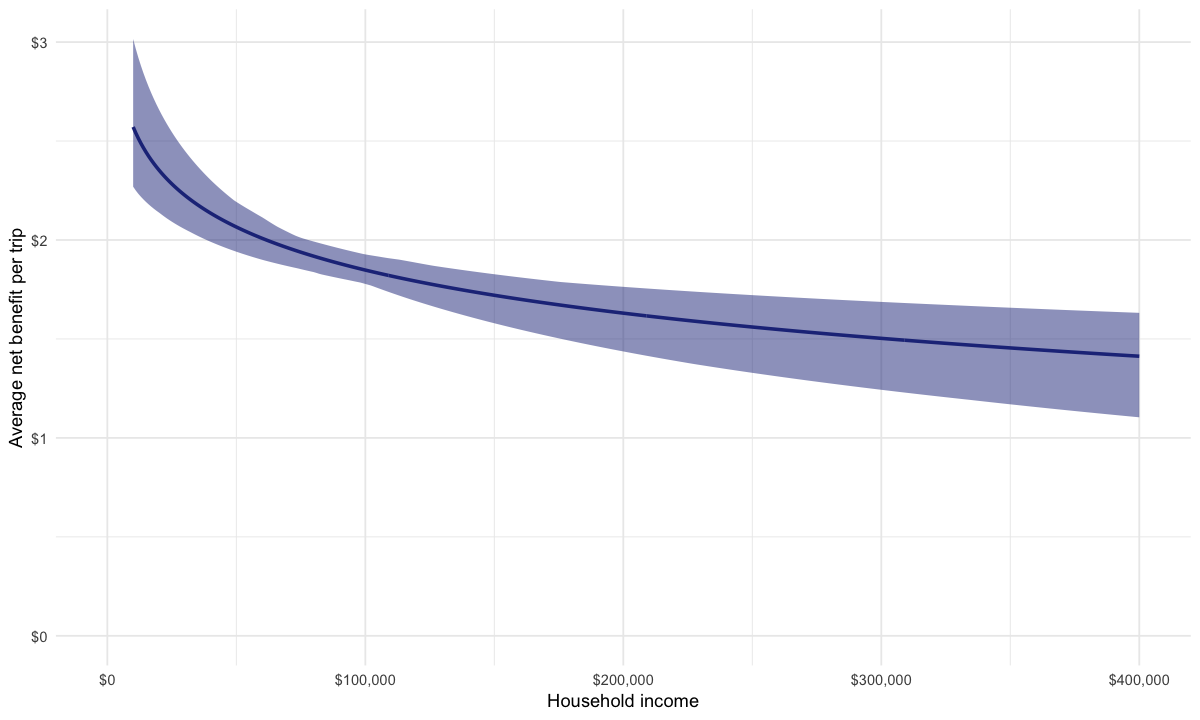

In [20]:
plot_relation(fips_benefits, net_benefit, trips, log_response=F, vary_slopes=F, annotate=T) +
    labs(x="Household income", y="Average net benefit per trip")
ggsave("../../../img/net_benefit_trip.png", height=3, width=5.5, dpi=320)

In [34]:
d.sav = plot_relation(fips_benefits, savings_benefit, trips, log_response=F, vary_slopes=F, data_only=T) %>% mutate(qty="Time savings")
d.rel = plot_relation(fips_benefits, reliability_benefit, trips, log_response=F, vary_slopes=F, data_only=T) %>% mutate(qty="Reliability")
d.rev = plot_relation(fips_benefits, revenue, trips, log_response=F, vary_slopes=F, data_only=T) %>% mutate(qty="Toll")

In [38]:
d.comp = bind_rows(d.sav, d.rel, d.rev)
head(d.comp)

low,high,inc,mean,qty
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
3.825318,4.972062,10000,4.296002,Time savings
3.801194,4.906660,11000,4.255853,Time savings
3.778286,4.846953,12000,4.219199,Time savings
3.757212,4.792028,13000,4.185482,Time savings
3.737723,4.741175,14000,4.154264,Time savings
3.719946,4.693832,15000,4.125201,Time savings


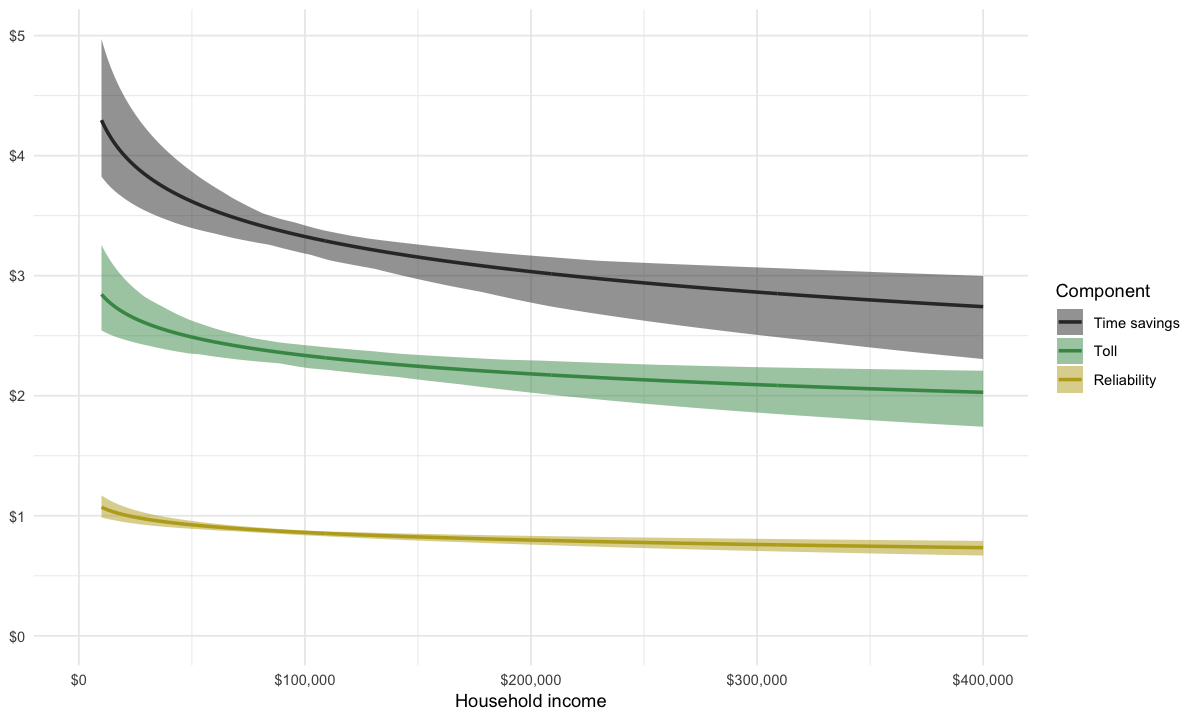

In [62]:
d.comp %>% 
    mutate(qty = fct_relevel(qty, "Time savings", "Toll")) %>%
ggplot(aes(inc, mean, ymin=low, ymax=high, fill=qty)) +
    geom_ribbon(alpha=0.5) +
    #geom_line(color="#223388", size=1) +
    geom_line(aes(color=qty), size=1) +
    scale_x_continuous(labels=scales::dollar, limits=c(0, max(d.comp$inc))) +
    scale_y_continuous(labels=scales::dollar, limits=c(0, NA)) + 
    scale_color_manual(values=c("#333333", "#449555", "#bbaa22")) +
    scale_fill_manual(values= c("#333333", "#449555", "#bbaa22")) +
    labs(x="Household income", y=NULL, color="Component", fill="Component")

ggsave("../../../img/components_trip.png", height=3, width=6.5, dpi=320)

[1] "157%"


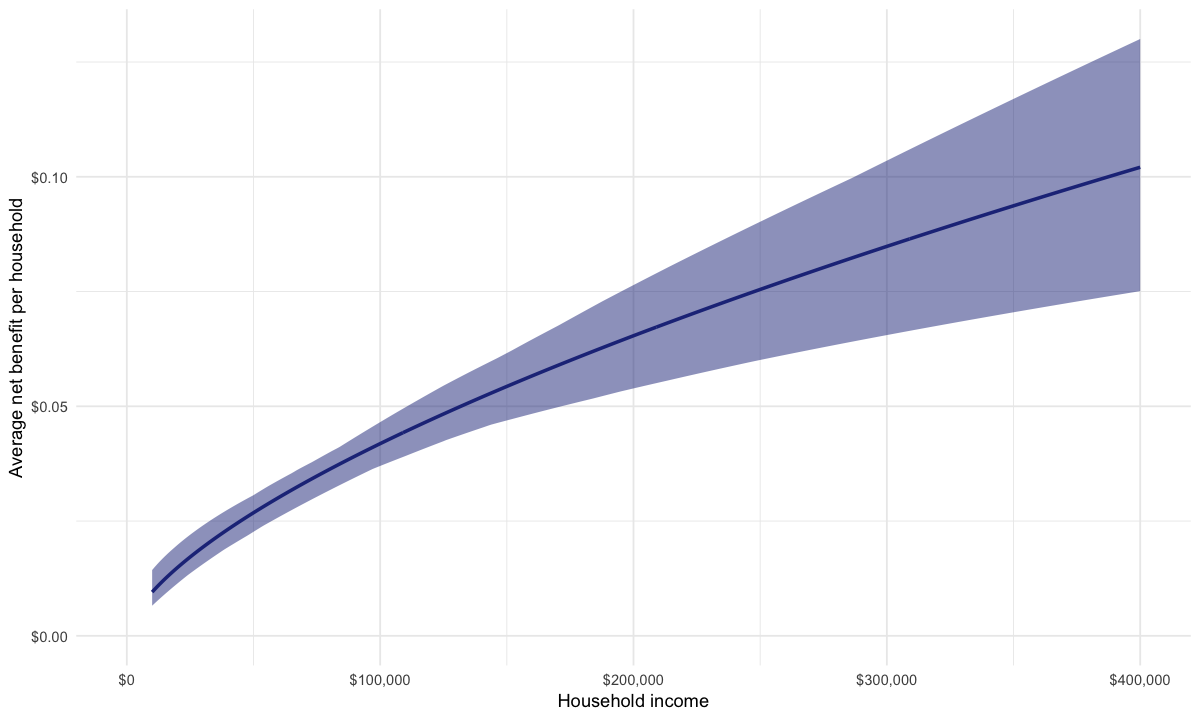

In [21]:
plot_relation(fips_benefits, net_benefit, households, log_response=T, annotate=T) +
    labs(x="Household income", y="Average net benefit per household")
ggsave("../../../img/net_benefit_household.png", height=3, width=5.5, dpi=320)

In [ ]:
with(fips_benefits, qqnorm(log(trips/households)))

[1] "148%"


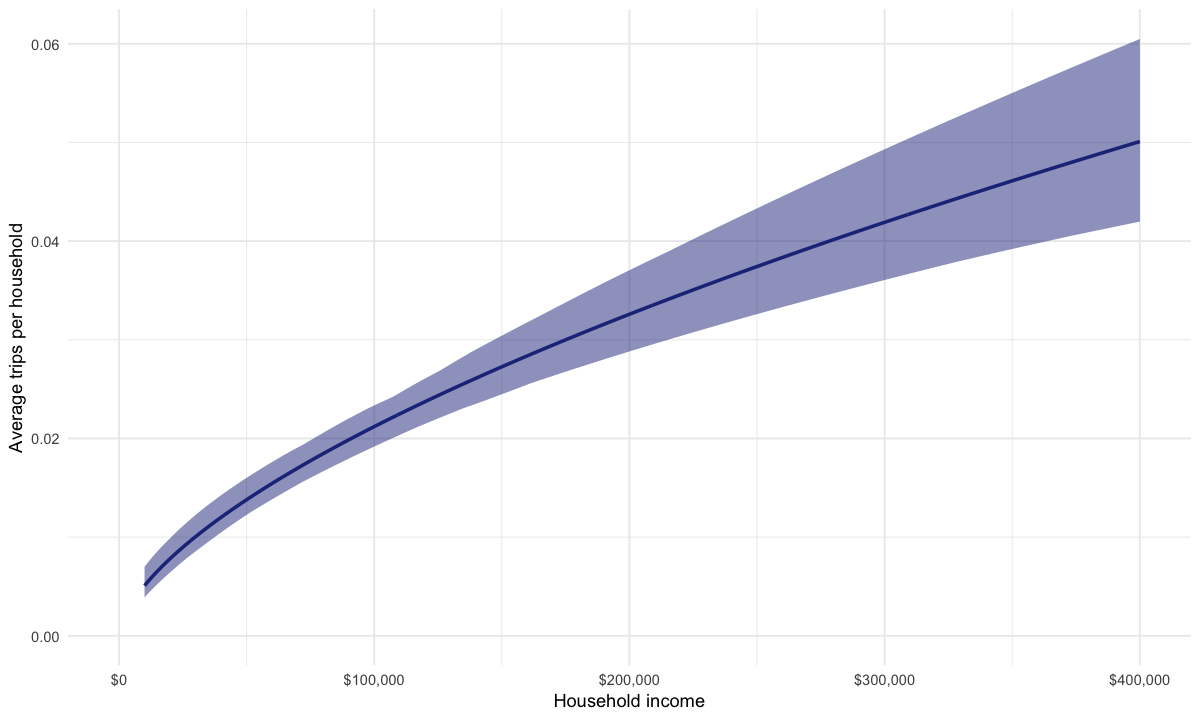

In [22]:
plot_relation(fips_benefits, trips, households, log_response=T, annotate=T) +
    labs(x="Household income", y="Average trips per household")
ggsave("../../../img/trips_household.png", height=3, width=5.5, dpi=320)

[1] "148%"


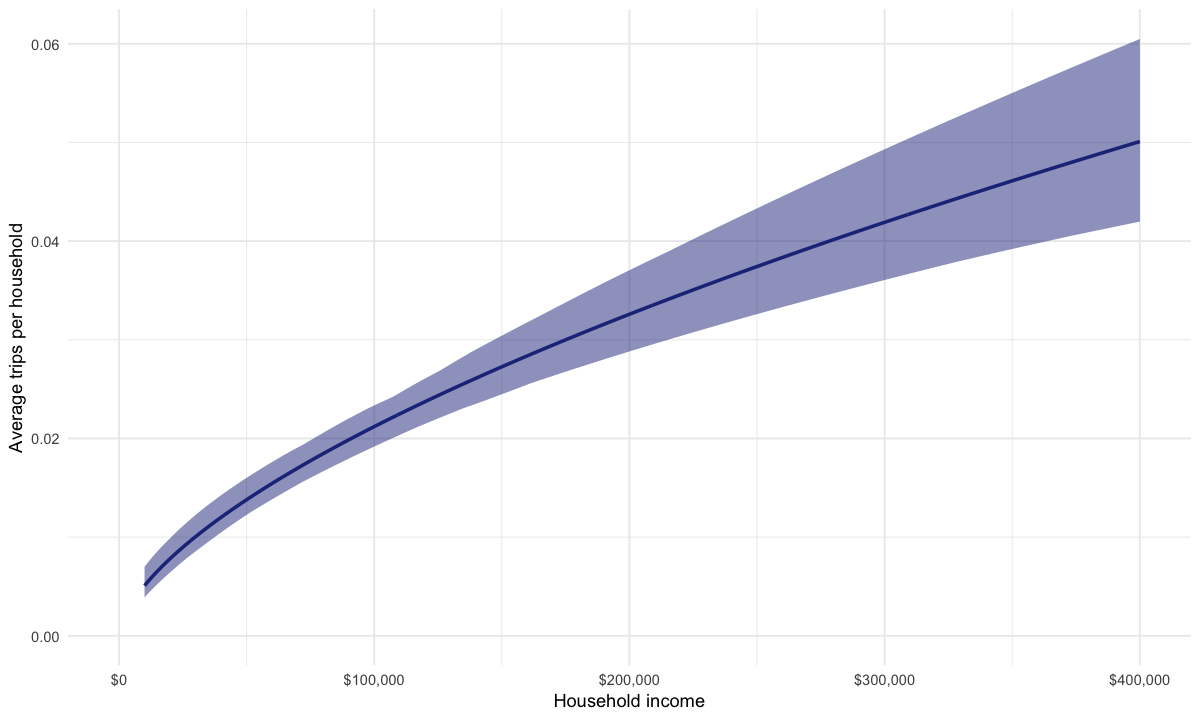

In [22]:
plot_relation(fips_benefits, trips, households, log_response=T, annotate=T) +
    labs(x="Household income", y="Average trips per user")

In [390]:
fips_benefits %>%
    ungroup() %>%
    filter(is_hov == 0) %>%
    filter(net_benefit>0, trips>0) %>%
    mutate(y = log(net_benefit/households),
           x = log(mean_inc/1e6)) %>%
    drop_na(x, y) %>%
    #lm(y ~ x, data=.) %>%
    #lmer(y ~ x + (1|county), data=.) %>%
    lmer(y ~ x + (1|tract), data=.) %>%
    summary

Linear mixed model fit by REML ['lmerMod']
Formula: y ~ x + (1 | tract)
   Data: .

REML criterion at convergence: 7122.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.1914 -0.4219  0.0922  0.5138  5.3210 

Random effects:
 Groups   Name        Variance Std.Dev.
 tract    (Intercept) 1.7414   1.3196  
 Residual             0.9647   0.9822  
Number of obs: 2082, groups:  tract, 736

Fixed effects:
            Estimate Std. Error t value
(Intercept) -1.69732    0.20293  -8.364
x            0.61154    0.08398   7.282

Correlation of Fixed Effects:
  (Intr)
x 0.964 

In [406]:
gc()

,used,(Mb),gc trigger,(Mb),limit (Mb),max used,(Mb)
Ncells,2518424,134.5,3977590,212.5,NA,3977590,212.5
Vcells,5139628,39.3,12275274,93.7,16384,12275274,93.7


In [14]:
benefits.d = fips_benefits %>%
    filter(is_hov==0) %>%
    left_join(select(acs, fips, starts_with("inc_"), med_inc), by="fips") %>%
    drop_na(mean_inc)

Warning message:
“Removed 72 rows containing non-finite values (stat_smooth).”Warning message:
“Removed 72 rows containing missing values (geom_point).”

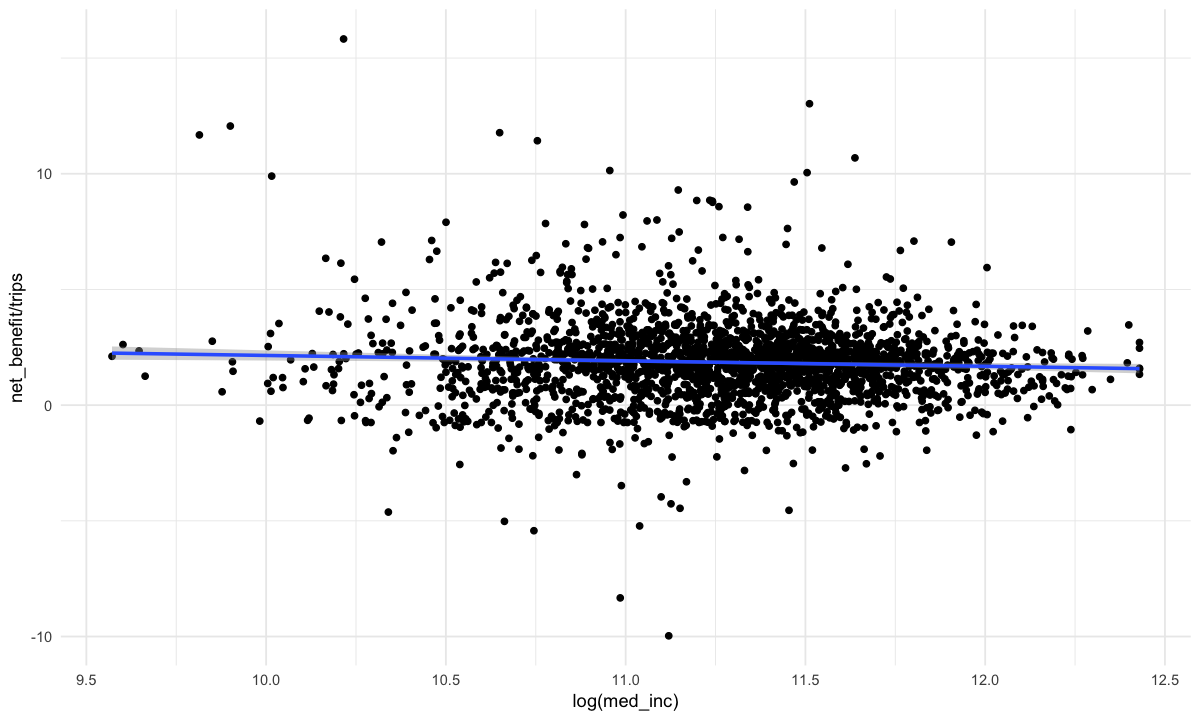

In [24]:
with(benefits.d, qplot(log(med_inc), net_benefit/trips)) + geom_smooth(method=lm)

In [34]:
lm(net_benefit/trips ~ log(mean_inc/1e6), data=benefits.d)


Call:
lm(formula = net_benefit/trips ~ log(mean_inc/1000000), data = benefits.d)

Coefficients:
          (Intercept)  log(mean_inc/1000000)  
               1.1600                -0.2941  


In [36]:
lmer(net_benefit/trips ~ log(mean_inc/1e6) + (log(mean_inc/1e6)|tract), data=benefits.d)
lmer(net_benefit/trips ~ log(mean_inc/1e6) + (1|tract), data=benefits.d)

boundary (singular) fit: see ?isSingular


Linear mixed model fit by REML ['lmerMod']
Formula: net_benefit/trips ~ log(mean_inc/1000000) + (log(mean_inc/1000000) |  
    tract)
   Data: benefits.d
REML criterion at convergence: 9409.83
Random effects:
 Groups   Name                  Std.Dev. Corr
 tract    (Intercept)           1.4057       
          log(mean_inc/1000000) 0.7764   1.00
 Residual                       1.7090       
Number of obs: 2361, groups:  tract, 760
Fixed Effects:
          (Intercept)  log(mean_inc/1000000)  
               1.0962                -0.3235  
convergence code 0; 1 optimizer warnings; 0 lme4 warnings 

Linear mixed model fit by REML ['lmerMod']
Formula: net_benefit/trips ~ log(mean_inc/1000000) + (1 | tract)
   Data: benefits.d
REML criterion at convergence: 9433.95
Random effects:
 Groups   Name        Std.Dev.
 tract    (Intercept) 0.3048  
 Residual             1.7567  
Number of obs: 2361, groups:  tract, 760
Fixed Effects:
          (Intercept)  log(mean_inc/1000000)  
               1.1809                -0.2855  